In [1]:
import pandas as pd
import sklearn_crfsuite, re
import numpy as np
import importlib, os
import logging, math
import json, nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def ngrams(tokens, gram_len=2):
    out = []
    for i in range(len(tokens)-gram_len+1):
        new_token = ' '.join(tokens[i:(i+gram_len)])
        out.append(new_token.strip())
    return out

def clean_tokens(tokens, to_replace='[^\w ]+'):
    tokens = [re.sub(to_replace, ' ', token) for token in tokens]
    return tokens

def tokenize(mystr, is_char=False):
    return mystr.split() if is_char is False else list(mystr)

In [3]:
def get_tokens(sentence, min_ngram=1, max_ngram=1, to_replace='[^\w ]+', is_char=False):
    # print("============================")
    # print("sentence before ",sentence)
    if is_char is False:
        sentence = re.sub('<[^<]+?>', ' ', sentence)
        sentence = re.sub(to_replace, '', sentence)
    # print("sentence after ",sentence)
    tokens = clean_tokens(tokenize(sentence), to_replace) if is_char is False else tokenize(sentence, is_char)
    # print("tokens before ",tokens)
    tokens = [token.strip() for token in tokens] if is_char is False else [token for token in tokens]
    # print("tokens after ",tokens)

    n_grams = []
    for gram_len in range(min_ngram, max_ngram+1):
        n_grams += ngrams(tokens, gram_len)
    # print("n_grams ",n_grams)
    # print("===================")
    return n_grams

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [20]:
print("Reading data...")
df = pd.read_csv('data/data.csv')

title = list(df.title.apply(str))
short_desc = list(df.short_description.apply(str))
long_desc = list(df.long_description.apply(str))

labels = [str(x).strip().split('__') for x in df.manual_curation_value]
# print("df head ",df.head())

Reading data...


In [6]:
vocab = {}
k = 0
for i in range(len(title)):
    corpus = (title[i] + " " + short_desc[i] + " " + long_desc[i]).encode("ascii", "ignore")
    corpus = corpus.decode()
    for j in corpus.split():
        if j not in vocab:
            vocab[j] = k
            k+=1
            
vocab['UNK'] = k+1
vocab['PAD'] = k+2

In [7]:
# train_sentences = []        
# train_labels = []

# for i in range(len(title)):
#     sentence = (title[i] + " " + short_desc[i] + " " + long_desc[i]).encode("ascii", "ignore")
#     sentence = sentence.decode()
#     #replace each token by its index if it is in vocab
#     #else use index of UNK
#     s = [vocab[token] if token in vocab 
#         else vocab['UNK']
#         for token in sentence.split(' ')]
#     train_sentences.append(s)

# # with open(train_labels_file) as f:
# #     for sentence in f.read().splitlines():
# #         #replace each label by its index
# #         l = [tag_map[label] for label in sentence.split(' ')]
# #         train_labels.append(l)
        
tag_map = {'B':0,'I':1,'O':2,'E':3,'S':4}


    

In [8]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [tag_map[label] for token, postag, label in sent]

def sent2tokens(sent):
    return [vocab[token] if token in vocab else vocab['UNK'] for token, postag, label in sent]

In [9]:
print("Creating BIOE tags...")
output_words, output_chars = [], []
train_labels,train_sentences,temp_labels = [],[],[]

for i in range(len(title)):
    corpus = (title[i] + " " + short_desc[i] + " " + long_desc[i]).encode("ascii", "ignore")
    corpus = corpus.decode()
    label = labels[i]
    
    word_tokens = get_tokens(corpus, min_ngram=1, max_ngram=1)
    char_tokens = get_tokens(corpus, min_ngram=1, max_ngram=1, is_char=True)
    # print("word_tokens ",word_tokens," char_tokens ",char_tokens)
    
    word_tokens = [w for w in word_tokens if len(w) > 0]
    char_tokens = [w for w in char_tokens if len(w) > 0]
    
    s = [vocab[token] if token in vocab 
        else vocab['UNK']
        for token in word_tokens]
    train_sentences.append(s)
    
    word_pos_tags = [y for x, y in nltk.pos_tag(word_tokens)]
    char_pos_tags = ['UNK']*len(char_tokens)
    # print("word_pos_tags ",word_pos_tags," char_pos_tags ",char_pos_tags)
    
    word_ner_tags = ['O']*len(word_tokens)
    char_ner_tags = ['O']*len(char_tokens)
    
    word_tokens_lc = [w.lower() for w in word_tokens]
    char_tokens_lc = [w.lower() for w in char_tokens]
    l2,temp = [],[]
    for j in range(len(label)):
        label[j] = label[j].encode("ascii", "ignore")
        label[j] = label[j].decode()
        gpt_word_tokens = get_tokens(label[j], min_ngram=1, max_ngram=1)
        gpt_char_tokens = get_tokens(label[j], min_ngram=1, max_ngram=1, is_char=True)
        # print("gpt_word_tokens ",gpt_word_tokens," gpt_char_tokens ",gpt_char_tokens)

        gpt_word_tokens = [w for w in gpt_word_tokens if len(w) > 0]
        gpt_char_tokens = [w for w in gpt_char_tokens if len(w) > 0]
        
        gpt_word_tokens_lc = [w.lower() for w in gpt_word_tokens]
        gpt_char_tokens_lc = [w.lower() for w in gpt_char_tokens]
        
        n1, n2 = len(gpt_word_tokens), len(gpt_char_tokens)
            
        for k in range(len(word_tokens)-n1+1):
            if (word_tokens[k:k+n1] == gpt_word_tokens or word_tokens_lc[k:k+n1] == gpt_word_tokens_lc) and word_ner_tags[k][0] == 'O':
                if n1 == 1:
                    word_ner_tags[k] = 'S'
                elif n1 == 2:
                    word_ner_tags[k] = 'B'
                    word_ner_tags[k+1] = 'E'
                else:
                    word_ner_tags[k] = 'B'
                    word_ner_tags[k+n1-1] = 'E'
                    word_ner_tags[k+1:k+n1-1] = ['I']*(n1-2)
                    
        for k in range(len(char_tokens)-n2+1):
            if (char_tokens[k:k+n2] == gpt_char_tokens or char_tokens_lc[k:k+n2] == gpt_char_tokens_lc) and char_ner_tags[k][0] == 'O':
                if n2 == 1:
                    char_ner_tags[k] = 'S'
                elif n2 == 2:
                    char_ner_tags[k] = 'B'
                    char_ner_tags[k+1] = 'E'
                else:
                    char_ner_tags[k] = 'B'
                    char_ner_tags[k+n2-1] = 'E'
                    char_ner_tags[k+1:k+n2-1] = ['I']*(n2-2)
              

        for l in word_ner_tags:
            l2.append(tag_map[l])
#         print("corpus is ",corpus)
#         print("label is ",label[j])
#         print("tags are ",l2)
#         print("word_ner_tags ",word_ner_tags)
#         print("char_ner_tags ",char_ner_tags)
        temp.append(label[j])
    train_labels.append([l2[0]])
    temp_labels.append(temp)
        
    
    q_words = zip(word_tokens, word_pos_tags, word_ner_tags)
    q_chars = zip(char_tokens, char_pos_tags, char_ner_tags)
#     print("q_words ",list(q_words)," q_chars ",list(q_chars))

    output_words.append(list(q_words))
    output_chars.append(list(q_chars))


Creating BIOE tags...


In [10]:
print("Creating train test split...")
train_indices, valid_indices = train_test_split(range(len(output_words)), test_size=0.2, random_state=0)

train_sents_words = [output_words[x] for x in train_indices if labels[x][0] != 'nan']
valid_sents_words = [output_words[x] for x in valid_indices]

train_sents_chars = [output_chars[x] for x in train_indices if labels[x][0] != 'nan']
valid_sents_chars = [output_chars[x] for x in valid_indices]

print("Creating train test data...")
# print("train_sents_words ",train_sents_words[5])

X_train_words = [sent2tokens(s) for s in train_sents_words]
y_train_words = [sent2labels(s) for s in train_sents_words]

# print("X_train_words ",X_train_words[5]," y_train_words ",y_train_words[5])
X_train_chars = [sent2features(s) for s in train_sents_chars]
y_train_chars = [sent2labels(s) for s in train_sents_chars]

X_valid_words = [sent2tokens(s) for s in valid_sents_words]
y_valid_words = [sent2labels(s) for s in valid_sents_words]

X_valid_chars = [sent2features(s) for s in valid_sents_chars]
y_valid_chars = [sent2labels(s) for s in valid_sents_chars]

print("Building word model...")
# word_crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
# word_crf.fit(X_train_words, y_train_words)

# print("Building char model...")
# char_crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
# char_crf.fit(X_train_chars, y_train_chars)


Creating train test split...
Creating train test data...
Building word model...


In [11]:
full_text = X_train_words+X_valid_words
full_labels = y_train_words+y_valid_words

In [12]:

#compute length of longest sentence in batch
batch_max_len = max([len(s) for s in full_text])

# train_sents_words = [train_sentences[x] for x in train_indices if train_labels[x][0] != 'nan']
# valid_sents_words = [train_sentences[x] for x in valid_indices]

# train_labels_final = [train_labels[x] for x in train_indices if train_labels[x][0] != 'nan']
# valid_labels = [train_labels[x] for x in valid_indices]
# batch_max_len_char = max([len(s) for s in X_train_chars])


In [13]:


#prepare a numpy array with the data, initializing the data with 'PAD' 
#and all labels with 2; initializing labels to 2 differentiates tokens 
#with tags from 'PAD' tokens
batch_data = vocab['PAD']*np.ones((len(full_text), batch_max_len))
batch_labels = 2*np.ones((len(full_text), batch_max_len))

# batch_data_char = 1*np.ones((len(X_train_chars), batch_max_len_char))
# batch_labels_char = -1*np.ones((len(X_train_chars), batch_max_len_char))

#copy the data to the numpy array
for j in range(len(full_text)):
    cur_len = len(full_text[j])
#     print("X_train_words[j] ",X_train_words[j]," batch_data[j][:cur_len] ",batch_data[j][:cur_len])
    batch_data[j][:cur_len] = full_text[j]
#     print("train_labels[j] ",len(train_labels[j])," len train_sentences[j] ",len(train_sentences[j])," temp_labels ",temp_labels[j])
    batch_labels[j][:cur_len] = full_labels[j]
    
# for j in range(len(X_train_chars)):
#     cur_len = len(X_train_chars[j])
#     batch_data_char[j][:cur_len] = X_train_chars[j]
#     batch_labels_char[j][:cur_len] = y_train_chars[j]

#since all data are indices, we convert them to torch LongTensors
batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)
# batch_data_char, batch_labels_char = torch.LongTensor(batch_data_char), torch.LongTensor(batch_labels_char)

#convert Tensors to Variables
batch_data, batch_labels = Variable(batch_data), Variable(batch_labels)
# batch_data_char, batch_labels_char = Variable(batch_data_char), Variable(batch_labels_char)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        #maps each token to an embedding_dim vector
        self.embedding = nn.Embedding(params['vocab_size']+1, params['embedding_dim'])

        #the LSTM takens embedded sentence
        self.lstm = nn.LSTM(params['embedding_dim'], params['lstm_hidden_dim'], batch_first=True)

        #fc layer transforms the output to give the final output layer
        self.fc = nn.Linear(params['lstm_hidden_dim'], params['number_of_tags'])
    
    def forward(self, s):
        #apply the embedding layer that maps each token to its embedding
        s = self.embedding(s)   # dim: batch_size x batch_max_len x embedding_dim
        
        #run the LSTM along the sentences of length batch_max_len
        s, _ = self.lstm(s)     # dim: batch_size x batch_max_len x lstm_hidden_dim                
        #reshape the Variable so that each row contains one token
        s = s.reshape(s.shape[0]*s.shape[1], s.shape[2])  # dim: batch_size*batch_max_len x lstm_hidden_dim
        #apply the fully connected layer and obtain the output for each token
        s = self.fc(s)          # dim: batch_size*batch_max_len x num_tags

        return F.log_softmax(s, dim=1)   # dim: batch_size*batch_max_len x num_tags

In [15]:
# def loss_fn(outputs, labels):
#     #reshape labels to give a flat vector of length batch_size*seq_len
#     labels = labels.view(-1)  

#     #mask out 'PAD' tokens
#     mask = (labels >= 0).float()

#     #the number of tokens is the sum of elements in mask
#     num_tokens = int(torch.sum(mask).item())

#     #pick the values corresponding to labels and multiply by mask
#     outputs = outputs[range(outputs.shape[0]), labels]*mask

#     #cross entropy loss for all non 'PAD' tokens
#     return -torch.sum(outputs)/num_tokens

In [16]:
class NMTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset
    self.source = np.array(batch_data, dtype = int)
    self.target = np.array(batch_labels, dtype = int)
    
  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.source)

dataset = NMTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.2
TEST_SIZE = int(NUM_INSTANCES * 0.2)

In [17]:
#train_data contains train_sentences and train_labels
#params contains batch_size
# dataset = (train_sentences, train_labels)
params = {'vocab_size':len(vocab),'embedding_dim':50,'lstm_hidden_dim':32,'number_of_tags':len(tag_map)}

model = Net(params)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

indices = list(range(NUM_INSTANCES))
test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 16, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = 16, sampler = test_sampler)

num_training_steps = 20
loss_trace,eval_loss = [],[]
for _ in tqdm(range(num_training_steps)):
    current_loss,epoch_loss = 0,0
    model.train()
    for i,(x,y) in enumerate(train_loader):
        #pass through model, perform backpropagation and updates
        outputs = model(x)
        output_dim = outputs.shape[-1]
#         print("initially outputs.shape ",outputs.shape ," y ",y.shape," y[1] ",y[1])
        outputs = outputs.view(-1, output_dim)
        y = y.view(-1)
#         print("outputs.shape ",outputs.shape ," y ",y.shape," y[1] ",y[1])
        loss = loss_fn(outputs,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
    loss_trace.append(current_loss)

    model.eval()
    for i, (x,y) in enumerate(test_loader):
        with torch.no_grad():
#             x, y  = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x) #turn off teacher forcing
            output_dim = outputs.shape[-1]

            outputs = outputs.view(-1, output_dim)
            y = y.view(-1)

            loss = loss_fn(outputs, y)

            epoch_loss += loss.item()
            
    eval_loss.append(epoch_loss)
        

100%|██████████| 20/20 [01:57<00:00,  5.88s/it]


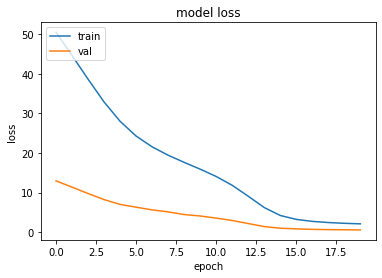

In [18]:
plt.plot(loss_trace)
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
predictions,orig_ans = [],[]
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(x) #turn off teacher forcing
        orig_ans.append(y)
        predictions.append(outputs.max(1)[1])
#         for output in outputs:
#             _, indices = output.max(-1)
#             predictions.append(indices.detach().cpu().numpy())
#         break